In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Convert mnist image files into tensor of 4D (numbers of images, Height, Width, color channel)
transform = transforms.ToTensor()

In [4]:
# Train our data
train_data = datasets.MNIST(root='/mnist_data', train=True, download=True, transform=transform)

In [5]:
# Test data
test_data = datasets.MNIST(root='/mnist_data', train=False, download=True, transform=transform)

In [8]:
# Create a small batch size for images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [10]:
# Define CNN model
# Describe convolutional layer and what its doing (2 convolutional layers)
# This is just an example 
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [11]:
# Grab one mnist record
for i, (X_Train, y_train) in enumerate(train_data):
  break

In [15]:
X_Train.shape

torch.Size([1, 28, 28])

In [16]:
x = X_Train.view(1, 1, 28, 28)

In [17]:
# Perform our first convolution
x = F.relu(conv1(x)) # Rectified linear unit for our activation function

In [20]:
#  1 single image, 6 is the filters we asked for, 26x26 is image (padding was added because outside of image is not relevant)
x.shape

torch.Size([1, 6, 26, 26])

In [21]:
# pass thru the pooling layer
x = F.max_pool2d(x, 2, 2) # kernel of 2 and stride of 2

In [23]:
x.shape # 26 / 2 = 13

torch.Size([1, 6, 13, 13])

In [24]:
x = F.relu(conv2(x))

In [26]:
x.shape # again, we did not set padding so we lose 2 pixels around outside of image

torch.Size([1, 16, 11, 11])

In [27]:
# Pooling layer 
x = F.max_pool2d(x, 2, 2)

In [29]:
x.shape

torch.Size([1, 16, 5, 5])

In [31]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    # Fully connected layers
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) # 2x2 kernel and stride of 2
    # Second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2) # 2x2 kernel and stride of 2

    # ReView to flatten it out
    X = X.view(-1, 16*5*5) # -1 so we can vary the batch size

    # Fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)


In [32]:
# Create and instance of our model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [33]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller the lr, the longer its going to take to train

In [34]:
import time
start_time = time.time()

# Create Variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop of epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 # Start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to the correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this specific batch. True=1, False=0, sum those up
    trn_corr += batch_corr # Keep track as we go along in training

    # Update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out results
    if b % 600 == 0:
      print(f'Epoch: {i}, Batch: {b}, Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad(): # No gradient so we dont update our weights and biases with our test data
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1, F=0 and sum away


  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)




current_time = time.time()
total = current_time - start_time
print(f'training took: {total/60} minutes!')

Epoch: 0, Batch: 600, Loss: 0.16236121952533722
Epoch: 0, Batch: 1200, Loss: 0.14594236016273499
Epoch: 0, Batch: 1800, Loss: 0.46197062730789185
Epoch: 0, Batch: 2400, Loss: 0.16650895774364471
Epoch: 0, Batch: 3000, Loss: 0.006768401712179184
Epoch: 0, Batch: 3600, Loss: 0.4466688632965088
Epoch: 0, Batch: 4200, Loss: 0.003655825974419713
Epoch: 0, Batch: 4800, Loss: 0.002664227271452546
Epoch: 0, Batch: 5400, Loss: 0.15809771418571472
Epoch: 0, Batch: 6000, Loss: 0.00045452718040905893
Epoch: 1, Batch: 600, Loss: 0.00367068056948483
Epoch: 1, Batch: 1200, Loss: 0.2531593441963196
Epoch: 1, Batch: 1800, Loss: 0.002257691929116845
Epoch: 1, Batch: 2400, Loss: 0.0019067501416429877
Epoch: 1, Batch: 3000, Loss: 0.01303138118237257
Epoch: 1, Batch: 3600, Loss: 0.5854852795600891
Epoch: 1, Batch: 4200, Loss: 0.03373146057128906
Epoch: 1, Batch: 4800, Loss: 0.0003217377816326916
Epoch: 1, Batch: 5400, Loss: 0.0004746452032122761
Epoch: 1, Batch: 6000, Loss: 0.12781091034412384
Epoch: 2, Ba

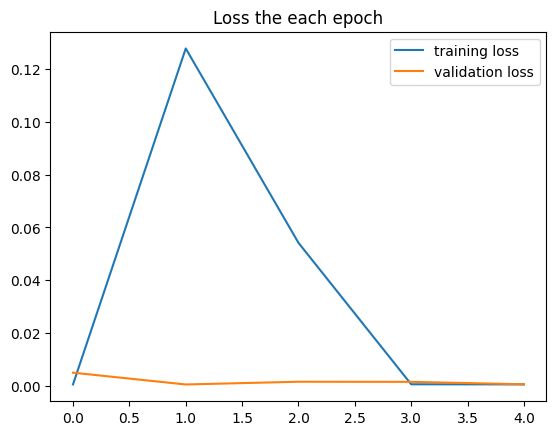

In [38]:
# graph the loss at each epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title("Loss the each epoch")
plt.legend()

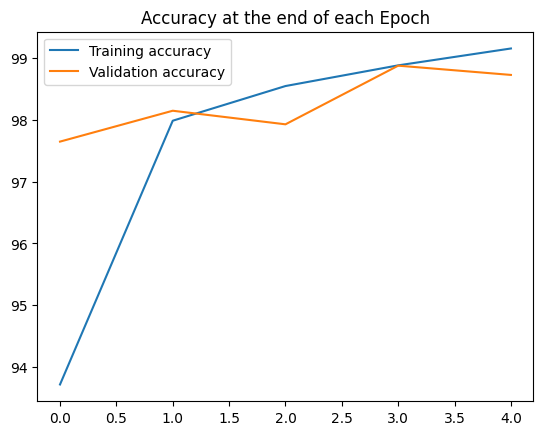

In [39]:
# Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training accuracy")
plt.plot([t/100 for t in test_correct], label="Validation accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [40]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [41]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [50]:
# Did for correct
correct.item()/len(test_data) * 100

98.72999999999999

In [54]:
# Grab an image
test_data[4143] # tensor with an image in it...at end, it shows us a label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [69]:
# grab just the data
test_data[1978][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [70]:
# Reshape it
test_data[1978][0].reshape(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

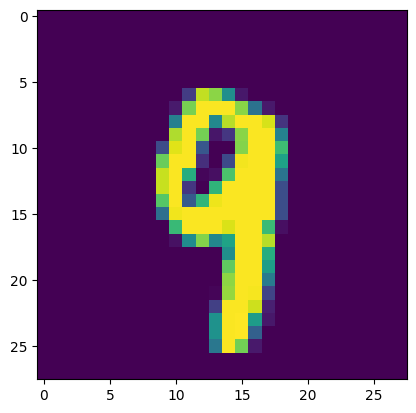

In [88]:
plt.imshow(test_data[4143][0].reshape(28, 28))

In [89]:
# Pass the image through the model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1, 1, 28, 28)) # Batch size of 1, 1 color channel, 28x28 imager

In [90]:
# Check new prediction...get probabilities
new_prediction

tensor([[-2.1076e+01, -1.6931e+01, -2.1042e+01, -1.5186e+01, -9.3421e+00,
         -1.7354e+01, -3.0037e+01, -1.3928e+01, -1.0949e+01, -1.0621e-04]])

In [91]:
new_prediction.argmax()

tensor(9)